In [1]:
import os,sys,glob
from matplotlib import colors as mcolors
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import seaborn as sns
from itertools import combinations
from sklearn.metrics import mean_squared_error
from scipy import stats

In [2]:
### subjects
def collectSubjectData(topPath,dataPath,groups,subjects,colors):

    # set up variables
    data_columns = ['subjectID','classID','colors']
    data =  pd.DataFrame([],columns=data_columns)

    # populate structure
    data['subjectID'] = [ f for g in groups for f in subjects[g] ]
    data['classID'] = [ g for g in groups for f in range(len(subjects[g]))]
    data['colors'] = [ colors[c] for c in colors for f in subjects[c]]

    # output data structure for records and any further analyses
    if not os.path.exists(dataPath):
        os.mkdir(dataPath)

    data.to_csv(dataPath+'subjects.csv',index=False)

    return data

### color dictionary
def createColorDictionary(data,measure,colorPalette):

    keys = data[measure].unique()
    values = sns.color_palette(colorPalette,len(keys))
    values = values.as_hex()

    colors_dict = dict(zip(keys,values))


    return colors_dict

### load parcellation stats data 
### load data 
def collectData(datatype,datatype_tags,tags,filename,subjects_data,colors,outPath):

    import requests
    import pandas as pd

    # grab path and data objects
    objects = requests.get('https://brainlife.io/api/warehouse/secondary/list/%s'%os.environ['PROJECT_ID']).json()
    
    # subjects and paths
    subjects = []
    paths = []
    finish_dates = []
    
    # set up output
    data = pd.DataFrame()

    # loop through objects
    for obj in objects:
        if obj['datatype']['name'] == datatype:
            if datatype_tags in obj['output']['datatype_tags']:
#                 if tags in obj['output']['tags']:
                    finish_dates = np.append(finish_dates,obj["finish_date"])
                    if obj['output']['meta']['subject'] in subjects:
                        index = np.where(subjects == obj['output']['meta']['subject'])
                        if finish_dates[index] < obj["finish_date"]:
                            subjects = np.delete(subjects,index)
                            paths = np.delete(paths,index)
                            subjects = np.append(subjects,obj['output']['meta']['subject'])
                            paths = np.append(paths,"input/"+obj["path"]+"/"+filename)
                    else:
                        subjects = np.append(subjects,obj['output']['meta']['subject'])
                        paths = np.append(paths,"input/"+obj["path"]+"/"+filename)
    
    # sort paths by subject order
    paths = [x for _,x in sorted(zip(subjects,paths))]

    for i in paths:
        tmpdata = pd.read_csv(i)                    
        if 'classID' in tmpdata.keys():
            tmpdata = pd.merge(tmpdata,subjects_data,on=['subjectID','classID'])
        else:
            tmpdata = pd.merge(tmpdata,subjects_data,on='subjectID')
        data = data.append(tmpdata,ignore_index=True)
            
    # replace empty spaces with nans
    data = data.replace(r'^\s+$', np.nan, regex=True)

    # output data structure for records and any further analyses
    # subjects.csv
    data.to_csv(outPath,index=False)

    return data

### cut nodes
def cutNodes(data,num_nodes,dataPath,foldername,savename):

    # identify inner n nodes based on num_nodes input
    total_nodes = len(data['nodeID'].unique())
    cut_nodes = int((total_nodes - num_nodes) / 2)

    # remove cut_nodes from dataframe
    data = data[data['nodeID'].between((cut_nodes)+1,(num_nodes+cut_nodes))]

    # replace empty spaces with nans
    data = data.replace(r'^\s+$', np.nan, regex=True)

    # output data structure for records and any further analyses
    if not os.path.exists(dataPath):
        os.mkdir(dataPath)

    data.to_csv(dataPath+'/'+foldername+'-'+savename+'.csv',index=False)

    return data

def computeMeanData(dataPath,data,outname):

    # make mean data frame
    data_mean =  data.groupby(['subjectID','classID','structureID']).mean().reset_index()
    data_mean['nodeID'] = [ 1 for f in range(len(data_mean['nodeID'])) ]

    # output data structure for records and any further analyses
    if not os.path.exists(dataPath):
        os.mkdir(dataPath)

    data_mean.to_csv(dataPath+outname+'.csv',index=False)

    return data_mean

### rank order effect size calculator
def computeRankOrderEffectSize(groups,subjects,tissue,measures,stat,measures_to_average,data_dir):

    comparison_array = list(combinations(groups,2)) # 2 x 2 array; 2 different comparisons, with two pairs per comparison. comparison_array[0] = ("run_1","run_2")
    es = {}
    roes = {}

    # compute effect size
    for compar in comparison_array:
        es[compar[0]+"_"+compar[1]] = pd.DataFrame([])
        tmp = pd.DataFrame([])
        tmp['structureID'] = stat['structureID'].unique()
        for m in measures:
            diff = stat[['structureID',m]][stat['classID'].str.contains(compar[0])].groupby('structureID').mean() - stat[['structureID',m]][stat['classID'].str.contains(compar[1])].groupby('structureID').mean()
            pooled_var = (np.sqrt((stat[['structureID',m]][stat['classID'].str.contains(compar[0])].groupby('structureID').std() ** 2 + stat[['structureID',m]][stat['classID'].str.contains(compar[1])].groupby('structureID').std() ** 2) / 2))
            effectSize = diff / pooled_var
            tmp[m+"_effect_size"] = list(effectSize[m])
        tmp.to_csv(data_dir+tissue+"_effect_sizes_"+compar[0]+"_"+compar[1]+".csv",index=False)
        es[compar[0]+"_"+compar[1]] = pd.concat([es[compar[0]+"_"+compar[1]],tmp],ignore_index=True)

    # rank order structures
    for ma in measures_to_average:
        if ma == ['ad','fa','md','rd','ga','ak','mk','rk']:
            model = 'tensor'
        elif ma == ['ndi','isovf','odi']:
            model = 'noddi'
        else:
            model = ma

        tmpdata = pd.DataFrame([])
        tmpdata['structureID'] = stat['structureID'].unique()
        for compar in comparison_array:
            if model == 'tensor':
                tmpdata[compar[0]+"_"+compar[1]+"_"+model+"_average_effect_size"] = es[compar[0]+"_"+compar[1]][['ad_effect_size','fa_effect_size','md_effect_size','rd_effect_size']].abs().mean(axis=1).tolist()
            elif model == 'noddi':
                tmpdata[compar[0]+"_"+compar[1]+"_"+model+"_average_effect_size"] = es[compar[0]+"_"+compar[1]][['ndi_effect_size','isovf_effect_size','odi_effect_size']].abs().mean(axis=1).tolist()
            else:
                tmpdata[compar[0]+"_"+compar[1]+"_"+model+"_average_effect_size"] = es[compar[0]+"_"+compar[1]][[ma+'_effect_size']].abs().mean(axis=1).tolist()

        tmpdata[model+"_average_effect_size"] =  tmpdata.mean(axis=1).tolist()
        tmpdata.to_csv(data_dir+model+"_average_"+tissue+"_effect_sizes.csv",index=False)
        roes[model] = tmpdata.sort_values(by=model+"_average_effect_size")['structureID'].tolist()

    return roes

def combineCorticalSubcortical(dataPath,corticalData,subcorticalData):

    # remove unnecessary columns
    corticalData = corticalData.drop(columns=['snr','thickness'])
    subcorticalData = subcorticalData.drop(columns=['parcID','number_of_voxels'])

    # merge data frames
    data = pd.concat([corticalData,subcorticalData],sort=False)

    # output data structure for records and any further analyses
    if not os.path.exists(dataPath):
        os.mkdir(dataPath)

    data.to_csv(dataPath+'graymatter_nodes.csv',index=False)

    # identify gray matter names
    graymatter_names = list(data['structureID'].unique())

    # output track names
    if not os.path.exists(dataPath):
        os.mkdir(dataPath)

    with open((dataPath+'graymatter_list.json'),'w') as gm_listf:
        json.dump(graymatter_names,gm_listf)

    return [graymatter_names,data]

def computeDistance(x,y,metric):

    from sklearn.metrics.pairwise import euclidean_distances
    from scipy.stats import wasserstein_distance

    if metric == 'euclidean':
        dist = euclidean_distances([x,y])[0][1]
    else:
        dist = wasserstein([x,y])[0][1]
        
    return dist

def profileFlipCheck(data,references_mean,subjects,structures,test_measure,flip_measures,dist_metric):
    
    flipped_subjects = []
    flipped_structures = []
    distance = []
    flipped_distance = []
    
    for s in subjects:
#         subj_data = data[data['subjectID'] == s]
        for i in structures:
#             struc_data = subj_data[subj_data['structureID'] == i]
            struc_data = data.loc[data['subjectID'] == s].loc[data['structureID'] == i]
#             references_data = references_mean[references_mean['structureID'] == i]
            references_data = references_mean.loc[references_mean['structureID'] == i]
            x = list(struc_data[test_measure].values.tolist())
            y = list(references_data[test_measure].values.tolist())
            dist = computeDistance(x,y,dist_metric)
            dist_flipped = computeDistance(list(np.flip(x)),y,dist_metric)
#             if np.abs(dist - dist_flipped) > 0.5:
            if dist > dist_flipped:
                if np.abs(dist - dist_flipped) > 0.1:
#                     print('%s %s appears to be flipped. flipping data to match reference. distance=%s, flipped=%s' %(s,i,str(dist),str(dist_flipped)))
#                     data[data['subjectID'] == s][data['structureID'] == i][flip_measures] = data[data['subjectID'] == s][data['structureID'] == i][flip_measures][::-1]
                    flipped_subjects = np.append(flipped_subjects,s)
                    flipped_structures = np.append(flipped_structures,i)
                    distance = np.append(distance,dist)
                    flipped_distance = np.append(flipped_distance,dist_flipped)
    
    output_summary = pd.DataFrame()
    output_summary['flipped_subjects'] = flipped_subjects
    output_summary['flipped_structures'] = flipped_structures
    output_summary['distance'] = distance
    output_summary['flipped_distance'] = flipped_distance
    
    return output_summary

def computeReferences(x,groupby_measures,index_measure,diff_measures):
    
    references_mean = x.groupby(groupby_measures).mean().reset_index(index_measure)
    references_sd = x.groupby(groupby_measures).std().reset_index(index_measure)
    references_sd[diff_measures] = references_sd[diff_measures] * 2
    
    return references_mean, references_sd

def computeDistance(x,y,metric):

    from sklearn.metrics.pairwise import euclidean_distances
    from scipy.stats import wasserstein_distance

    if metric == 'euclidean':
        dist = euclidean_distances([x,y])[0][1]
    else:
        dist = wasserstein([x,y])[0][1]
        
    return dist

def outlierDetection(data,references_mean,references_sd,subjects,structures,measures,threshold,dist_metric):
    
    import numpy as np, pandas as pd

    outliers_subjects = []
    outliers_structures = []
    outliers_measures = []
    outliers_metrics = []
    dist = []

#     for s in subjects:
#         subj_data = data[data['subjectID'] == s]
    for i in structures:
        subj_data = data[data['structureID'] == i]
        references_data = references_mean[references_mean['structureID'] == i]
        for m in measures:
            for s in subjects:
                x = list(subj_data[m].values.tolist())
                y = list(references_data[m].values.tolist())
                dist = np.append(dist,computeDistance(x,y,dist_metric))
                
            dist_percentiles = [np.percentile(dist,5),np.percentile(dist,95)]
            outliers = np.any((dist < dist_percentiles[0])|(dist > dist_percentiles[1]))
#             for o in outliers:
                
# #                 if np.abs(dist) > threshold:
# #                     outliers_subjects = np.append(outliers_subjects,s)
# #                     outliers_structures = np.append(outliers_structures,i)
# #                     outliers_measures = np.append(outliers_measures,m)
# #                     outliers_metrics = np.append(outliers_metrics,dist)

#     outliers_dataframe = pd.DataFrame()
#     outliers_dataframe['subjectID'] = outliers_subjects
#     outliers_dataframe['structureID'] = outliers_structures
#     outliers_dataframe['measures'] = outliers_measures
#     outliers_dataframe['distance'] = outliers_metrics
    
#     return outliers_dataframe

### scatter plot related scripts
# groups data by input measure and computes mean for each value in that column. x_stat is a pd dataframe, with each row being a single value, and each column being a different ID value or measure
def averageWithinColumn(x_stat,y_stat,x_measure,y_measure,measure):

    X = x_stat.groupby(measure).mean()[x_measure].tolist()
    Y = y_stat.groupby(measure).mean()[y_measure].tolist()

    return X,Y

# groups data by input measure and creates an array by appending data into x and y arrays. x_stat and y_stat are pd dataframes, with each row being a single value, and each column being a different ID value or measure
# designed for test retest. x_stat and y_stat should have the same number of rows. but more importantly, should correspond to the same source (i.e. subject)
# can be same pd.dataframe, but indexing of specific subject groups
def appendWithinColumn(x_stat,y_stat,x_measure,y_measure,measure):

    X,Y = [np.array([]),np.array([])]
    for i in range(len(x_stat[measure].unique())):
        x = x_stat[x_stat[measure] == x_stat[measure].unique()[i]][x_measure]
        y = y_stat[y_stat[measure] == y_stat[measure].unique()[i]][y_measure]

        if np.isnan(x).any() or np.isnan(y).any():
            print("skipping %s due to nan" %x_stat[measure].unique()[i])
        else:
            # checks to make sure the same data
            if len(x) == len(y):
                X = np.append(X,x)
                Y = np.append(Y,y)

    return X,Y

# unravels networks. x_stat and y_stat should be S x M, where S is the number of subjects and M is the adjacency matrix for that subject
def ravelNetwork(x_stat,y_stat):

    import numpy as np

    X = np.ravel(x_stat).tolist()
    Y = np.ravel(y_stat).tolist()

    return X,Y

# unravels nonnetwork data. x_stat and y_stat should be pd dataframes. x_measure and y_measure are the measure to unrvavel. 
# designed for test retest. x_stat and y_stat should have the same number of rows. but more importantly, should correspond to the same source (i.e. subject)
# can be same pd.dataframe, but indexing of specific subject groups
def ravelNonNetwork(x_stat,y_stat,x_measure,y_measure):

    X = x_stat[x_measure].to_list()
    Y = y_stat[y_measure].to_list()

    return X,Y

# wrapper function to call either of the above scripts based on user input
def setupData(x_data,y_data,x_measure,y_measure,ravelAverageAppend,isnetwork,measure):

    x_stat = x_data
    y_stat = y_data

    if ravelAverageAppend == 'average':
        X,Y = averageWithinColumn(x_stat,y_stat,x_measure,y_measure,measure)
    elif ravelAverageAppend == 'append':
        X,Y = appendWithinColumn(x_stat,y_stat,x_measure,y_measure,measure)
    elif ravelAverageAppend == 'ravel':
        if isnetwork == True:
            X,Y = ravelNetwork(x_stat,y_stat)
        else:
            X,Y = ravelNonNetwork(x_stat,y_stat,x_measure,y_measure)

    return x_stat,y_stat,X,Y

# function to shuffle data and colors
def shuffleDataAlg(X,Y,hues):

    from sklearn.utils import shuffle

    X,Y,hues = shuffle(X,Y,hues)

    return X,Y,hues

# simple display or figure save function
def saveOrShowImg(dir_out,x_measure,y_measure,img_name):
    import os,sys 
    import matplotlib.pyplot as plt
    import warnings
    
    with warnings.catch_warnings():
        # this will suppress all warnings in this block
        warnings.simplefilter("ignore")
 
        # save or show plot
        if dir_out:
            if not os.path.exists(dir_out):
                os.mkdir(dir_out)

            if x_measure == y_measure:
                img_name_eps = img_name+'_'+x_measure+'.eps'
                img_name_png = img_name+'_'+x_measure+'.png'
                img_name_svg = img_name+'_'+x_measure+'.svg'
            else:
                img_name_eps = img_name+'_'+x_measure+'_vs_'+y_measure+'.eps'
                img_name_png = img_name+'_'+x_measure+'_vs_'+y_measure+'.png'
                img_name_svg = img_name+'_'+x_measure+'_vs_'+y_measure+'.svg'

            plt.savefig(os.path.join(dir_out, img_name_eps),transparent=True)
            plt.savefig(os.path.join(dir_out, img_name_png))     
    #         plt.savefig(os.path.join(dir_out, img_name_svg))
        else:
            plt.show()

        plt.close()
    
# uses seaborn's relplot function to plot data for each unique value in a column of a pandas dataframe (ex. subjects, structureID). useful for supplementary figures or sanity checking or preliminary results
# column measure is the measure within which each unique value will have its own plot. hue_measure is the column to use for coloring the data. column_wrap is how many panels you want per row
# trendline, depending on user input, can either be the linear regression between x_data[x_measure] and y_data[y_measure] or the line of equality
# dir_out and img_name are the directory where the figures should be saved and the name for the image. will save .eps and .png
# if want to view plot instead of save, set dir_out=""
def relplotScatter(x_data,y_data,x_measure,y_measure,column_measure,hue_measure,column_wrap,trendline,dir_out,img_name):

    import os,sys
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import mean_squared_error

    # grab data: CANNOT BE AVERAGE
    [x_stat,y_stat,X,Y] = setupData(x_data,y_data,x_measure,y_measure,'ravel',False,hue_measure)

    p = sns.relplot(x=X,y=Y,col=x_stat[column_measure],hue=x_stat[hue_measure],kind="scatter",s=100,col_wrap=column_wrap)

    # setting counter. looping through axes to add important info and regression lines
    i = 0
    for ax in p.axes.flat:
        x_lim,y_lim = [ax.get_xlim(),ax.get_ylim()]

        if trendline == 'equality':
            ax.plot(x_lim,y_lim,ls="--",c='k')
        elif trendline == 'linreg':
            m,b = np.polyfit(p.data[p.data[column_measure] == x_stat[column_measure].unique()[i]]['x'],p.data[p.data[column_measure] == y_stat[column_measure].unique()[i]]['y'],1)
            ax.plot(ax.get_xticks(),m*ax.get_xticks() + b)
            plt.text(0.1,0.7,'y = %s x + %s' %(str(np.round(m,4)),str(np.round(b,4))),fontsize=12,verticalalignment="top",horizontalalignment="left",transform=ax.transAxes)

        ax.set_xlim(x_lim)
        ax.set_ylim(y_lim)
        ax.set_xlabel(x_measure)
        ax.set_ylabel(y_measure)

        # compute correlation for each subject and add to plots
        corr = np.corrcoef(p.data[p.data[column_measure] == x_stat[column_measure].unique()[i]]['x'],p.data[p.data[column_measure] == y_stat[column_measure].unique()[i]]['y'])[1][0]
        plt.text(0.1,0.9,'r = %s' %str(np.round(corr,4)),fontsize=12,verticalalignment="top",horizontalalignment="left",transform=ax.transAxes)

        # compute rmse for each subject and add to plots
        rmse = np.sqrt(mean_squared_error(p.data[p.data[column_measure] == x_stat[column_measure].unique()[i]]['x'],p.data[p.data[column_measure] == y_stat[column_measure].unique()[i]]['y']))
        plt.text(0.1,0.8,'rmse = %s' %str(np.round(rmse,4)),fontsize=12,verticalalignment="top",horizontalalignment="left",transform=ax.transAxes)

        # update counter
        i = i+1

    # save image or show image
    saveOrShowImg(dir_out,x_measure,y_measure,img_name)

# uses seaborn's scatter function to plot data from x_data[x_measure] and y_data[y_measure]. useful for publication worthy figure
# column measure is the measure within which data will be summarized. hue_measure is the column to use for coloring the data. 
# ravelAverageAppend is a string value of either 'append' to use the append function, 'ravel' to use the ravel function, or 'average' to use the average function
# trendline, depending on user input, can either be the linear regression between x_data[x_measure] and y_data[y_measure] or the line of equality
# dir_out and img_name are the directory where the figures should be saved and the name for the image. will save .eps and .png
# if want to view plot instead of save, set dir_out=""
def singleplotScatter(colors_dict,x_data,y_data,x_measure,y_measure,logX,column_measure,hue_measure,ravelAverageAppend,trendline,shuffleData,dir_out,img_name):

    import os,sys
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import mean_squared_error

    # grab data
    [x_stat,y_stat,X,Y] = setupData(x_data,y_data,x_measure,y_measure,ravelAverageAppend,False,column_measure)
    colors = sns.color_palette('colorblind',len(x_stat[hue_measure]))

    if ravelAverageAppend == 'average':
        if isinstance(x_stat[hue_measure].unique()[0],str):
            hues = x_stat[hue_measure].unique().tolist()
        else:
            hues = x_stat.groupby(column_measure).mean()[hue_measure].tolist()
    else:
        hues = list(x_stat[hue_measure])

    if shuffleData == True:
        X,Y,hues = shuffleDataAlg(X,Y,hues)

    if logX == True:
        X = np.log10(X)

    if colors_dict:
        p = sns.scatterplot(x=X,y=Y,hue=hues,s=100,palette=colors_dict,legend=False)
    else:
        p = sns.scatterplot(x=X,y=Y,hue=hues,s=100)					

    # set x and ylimits, plot line of equality, and legend
    if x_measure == y_measure:
        p.axes.axis('square')
        y_ticks = p.axes.get_yticks()
        p.axes.set_xticks(y_ticks)
        p.axes.set_yticks(p.axes.get_xticks())
        p.axes.set_ylim(p.axes.get_xlim())
        p.axes.set_xlim(p.axes.get_xlim())

    x_lim,y_lim = [p.axes.get_xlim(),p.axes.get_ylim()]

    # trendline: either equality or linear regression
    if trendline == 'equality':
        p.plot(x_lim,y_lim,ls="--",c='k')
    elif trendline == 'linreg':
        m,b = np.polyfit(X,Y,1)
        p.plot(p.get_xticks(),m*p.get_xticks() + b,c='k')
        plt.text(0.1,0.7,'y = %s x + %s' %(str(np.round(m,4)),str(np.round(b,4))),fontsize=16,verticalalignment="top",horizontalalignment="left",transform=p.axes.transAxes)
    elif trendline == 'groupreg':
        for g in range(len(groups)):
            if stat_name == 'volume':
                slope, intercept, r_value, p_value, std_err = stats.linregress(np.log10(stat[['structureID',stat_name]][stat['subjectID'].str.contains('%s_' %str(g+1))].groupby('structureID',as_index=False).mean()[stat_name]),stat[['structureID',dm]][stat['subjectID'].str.contains('%s_' %str(g+1))].groupby('structureID',as_index=False).mean()[dm])
                ax = sns.regplot(x=np.log10(stat[['structureID',stat_name]][stat['subjectID'].str.contains('%s_' %str(g+1))].groupby('structureID',as_index=False).mean()[stat_name]),y=stat[['structureID',dm]][stat['subjectID'].str.contains('%s_' %str(g+1))].groupby('structureID',as_index=False).mean()[dm],color=colors[groups[g]],scatter=True,line_kws={'label':"y={0:.5f}x+{1:.4f}".format(slope,intercept)})

            else:
                slope, intercept, r_value, p_value, std_err = stats.linregress(stat[['structureID',stat_name]][stat['subjectID'].str.contains('%s_' %str(g+1))].groupby('structureID',as_index=False).mean()[stat_name],stat[['structureID',dm]][stat['subjectID'].str.contains('%s_' %str(g+1))].groupby('structureID',as_index=False).mean()[dm])
                ax = sns.regplot(x=stat[['structureID',stat_name]][stat['subjectID'].str.contains('%s_' %str(g+1))].groupby('structureID',as_index=False).mean()[stat_name],y=stat[['structureID',dm]][stat['subjectID'].str.contains('%s_' %str(g+1))].groupby('structureID',as_index=False).mean()[dm],color=colors[groups[g]],scatter=True,line_kws={'label':"y={0:.5f}x+{1:.4f}".format(slope,intercept)})

            ax.legend()


    # compute correlation for each subject and add to plots
    corr = np.corrcoef(X,Y)[1][0]
    plt.text(0.1,0.9,'r = %s' %str(np.round(corr,4)),fontsize=16,verticalalignment="top",horizontalalignment="left",transform=p.axes.transAxes)

    # compute rmse for each subject and add to plots
    rmse = np.sqrt(mean_squared_error(X,Y))
    plt.text(0.1,0.8,'rmse = %s' %str(np.round(rmse,4)),fontsize=16,verticalalignment="top",horizontalalignment="left",transform=p.axes.transAxes)

    # set title and x and y labels
    plt.title('%s vs %s' %(x_measure,y_measure),fontsize=20)
    plt.xlabel(x_measure,fontsize=18)
    plt.ylabel(y_measure,fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

    # remove top and right spines from plot
    p.axes.spines["top"].set_visible(False)
    p.axes.spines["right"].set_visible(False)

    # save image or show image
    saveOrShowImg(dir_out,x_measure,y_measure,img_name)

# uses seaborn's scatter function to plot data from x_data[x_measure] and y_data[y_measure] for network correlations. useful for publication worthy figure
# column measure is the measure within which data will be summarized.
# ravelAverageAppend is a string value of either 'append' to use the append function, 'ravel' to use the ravel function, or 'average' to use the average function
# trendline, depending on user input, can either be the linear regression between x_data[x_measure] and y_data[y_measure] or the line of equality
# dir_out and img_name are the directory where the figures should be saved and the name for the image. will save .eps and .png
# if want to view plot instead of save, set dir_out=""
def networkScatter(colors_dict,hues,groups,subjects,x_data,y_data,network_measure,shuffleData,trendline,dir_out,img_name):

    import os,sys
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import mean_squared_error

    # generate new figure for each
    p = plt.figure()

    # grab data
    [x_stat,y_stat,X,Y] = setupData(x_data,y_data,"","","ravel",True,"")

    # additional network setup
    # hues = sns.color_palette(colormap,len(X))
    # hues = hues.as_hex()
    # keys = [ i for i in range(len(X)) ]
    # colors_dict = dict(zip(hues,hues))

    if shuffleData == True:
        X,Y,hues = shuffleDataAlg(X,Y,hues)

    # if colors_dict:
        # p = sns.scatterplot(x=X,y=Y,hue=hues,s=100,palette=colors_dict,legend=False)
    # else:
    p = sns.scatterplot(x=X,y=Y,hue=hues,s=100,palette=colors_dict,legend=False)

    # set x and ylimits, plot line of equality, and legend
    p.axes.axis('square')
    y_ticks = p.axes.get_yticks()
    p.axes.set_xticks(y_ticks)
    p.axes.set_yticks(p.axes.get_xticks())
    p.axes.set_ylim(p.axes.get_xlim())
    p.axes.set_xlim(p.axes.get_xlim())

    x_lim,y_lim = [p.axes.get_xlim(),p.axes.get_ylim()]

    # trendline: either equality or linear regression
    if trendline == 'equality':
        p.plot(x_lim,y_lim,ls="--",c='k')
    elif trendline == 'linreg':
        m,b = np.polyfit(X,Y,1)
        p.plot(p.get_xticks(),m*p.get_xticks() + b,c='k')
        plt.text(0.1,0.7,'y = %s x + %s' %(str(np.round(m,4)),str(np.round(b,4))),fontsize=16,verticalalignment="top",horizontalalignment="left",transform=p.axes.transAxes)

    # compute correlation for each subject and add to plots
    corr = np.corrcoef(X,Y)[1][0]
    plt.text(0.1,0.9,'r = %s' %str(np.round(corr,4)),fontsize=16,verticalalignment="top",horizontalalignment="left",transform=p.axes.transAxes)

    # compute rmse for each subject and add to plots
    rmse = np.sqrt(mean_squared_error(X,Y))
    plt.text(0.1,0.8,'rmse = %s' %str(np.round(rmse,4)),fontsize=16,verticalalignment="top",horizontalalignment="left",transform=p.axes.transAxes)

    # set title and x and y labels
    plt.title('%s %s vs %s' %(network_measure,groups[0],groups[1]),fontsize=20)
    plt.xlabel(groups[0],fontsize=18)
    plt.ylabel(groups[1],fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

    # remove top and right spines from plot
    p.axes.spines["top"].set_visible(False)
    p.axes.spines["right"].set_visible(False)

    # save image or show image
    saveOrShowImg(dir_out,network_measure+'_'+groups[0],network_measure+'_'+groups[1],img_name)

# uses matplotlib.pyplot's hist2d function to plot data from x_data[x_measure] and y_data[y_measure]. useful for supplementary figure or debugging or publication worthy figure
# column measure is the measure within which data will be summarized. hue_measure is the column to use for coloring the data. 
# ravelAverageAppend is a string value of either 'append' to use the append function, 'ravel' to use the ravel function, or 'average' to use the average function
# trendline, depending on user input, can either be the linear regression between x_data[x_measure] and y_data[y_measure] or the line of equality
# dir_out and img_name are the directory where the figures should be saved and the name for the image. will save .eps and .png
# if want to view plot instead of save, set dir_out=""
def plot2dHist(x_data,y_data,x_measure,y_measure,column_measure,hue_measure,ravelAverageAppend,trendline,shuffleData,dir_out,img_name):

    import os,sys
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import mean_squared_error

    # grab data
    [x_stat,y_stat,X,Y] = setupData(x_data,y_data,x_measure,y_measure,ravelAverageAppend,False,column_measure)

    if ravelAverageAppend == 'average':
        if isinstance(x_stat[hue_measure].unique()[0],str):
            hues = x_stat[hue_measure].unique().tolist()
        else:
            hues = x_stat.groupby(column_measure).mean()[hue_measure].tolist()
    else:
        hues = list(x_stat[hue_measure])

    if shuffleData == True:
        X,Y,hues = shuffleDataAlg(X,Y,hues)


    # generate new figure for each
    p = plt.figure()

    plt.hist2d(x=X,y=Y,cmin=1,density=False,bins=(len(X)/10),cmap='magma',vmax=(len(X)/10))
    plt.colorbar()

    # set title and x and y labels

    plt.title('%s vs %s' %(x_measure,y_measure),fontsize=20)
    plt.xlabel(x_measure,fontsize=18)
    plt.ylabel(y_measure,fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

    # # remove top and right spines from plot
    # p.axes.spines["top"].set_visible(False)
    # p.axes.spines["right"].set_visible(False)

    # save image or show image
    saveOrShowImg(dir_out,x_measure,y_measure,img_name)

### tract profile data
# uses matplotlib.pyplot's plot and fill_between functions to plot tract profile data from stat. useful for publication worthy figure
# requires stat to be formatted in way of AFQ_Brwoser and Yeatman et al 2018 () 'nodes.csv' files
# groups is a list array of names of groups found in 'classID' of stat to plot
# colors is a dictionary with the classID from groups set as the key and a color name as the value. will use these colors in profiles
# tracks is a list array that will be looped through to make plots. if only one track is wanted, set structures=['structure_name'], with 'structure_name' being the name of the track in the 'structureID' field of stat
# stat is the pandas dataframe with all of the profile data. each row is a node for a track for a subject
# diffusion_measures is a list array of the column measures found within stat. was developed with diffusion MRI metrics in mind, but can be any measure
# summary_method is a string of either 'mean' to plot the average profile data, 'max' to plot max, 'min' to plot min, and 'median' to plot median
# error_method is a string of either 'std' for the error bars to be set to the standard deviation or 'sem' for standard error of mean
# dir_out and imgName are the directory where the figures should be saved and the name for the image. will save .pdf and .png
# if want to view plot instead of save, set dir_out=""
def plotProfiles(structures,stat,diffusion_measures,summary_method,error_method,dir_out,img_name):

    import matplotlib.pyplot as plt
    import os,sys
    import seaborn as sns
    from scipy import stats
    import numpy as np
    import warnings
    
    warnings.filterwarnings('ignore')

    # loop through all structures
    for t in structures:
        print(t)
        # loop through all measures
        for dm in diffusion_measures:
            print(dm)

            imgname=img_name+"_"+t+"_"+dm

            # generate figures
            fig = plt.figure(figsize=(15,15))
#             fig = plt.figure()
            fig.patch.set_visible(False)
            p = plt.subplot()

            # set title and catch array for legend handle
            plt.title("%s Profiles %s: %s" %(summary_method,t,dm),fontsize=20)

            # loop through groups and plot profile data
            for g in range(len(stat.classID.unique())):
                # x is nodes
                x = stat['nodeID'].unique()

                # y is summary (mean, median, max, main) profile data
                if summary_method == 'mean':
                    y = stat[stat['classID'] == stat.classID.unique()[g]].groupby(['structureID','nodeID']).mean()[dm][t]
                elif summary_method == 'median':
                    y = stat[stat['classID'] == stat.classID.unique()[g]].groupby(['structureID','nodeID']).median()[dm][t]
                elif summary_method == 'max':
                    y = stat[stat['classID'] == stat.classID.unique()[g]].groupby(['structureID','nodeID']).max()[dm][t]
                elif summary_method == 'min':
                    y = stat[stat['classID'] == stat.classID.unique()[g]].groupby(['structureID','nodeID']).min()[dm][t]

                # error bar is either: standard error of mean (sem), standard deviation (std)
                if error_method == 'sem':
                    err = stat[stat['classID'] == stat.classID.unique()[g]].groupby(['structureID','nodeID']).std()[dm][t] / np.sqrt(len(stat[stat['classID'] == stat.classID.unique()[g]]['subjectID'].unique()))
                else:
                    err = stat[stat['classID'] == stat.classID.unique()[g]].groupby(['structureID','nodeID']).std()[dm][t]

                # plot summary
                plt.plot(x,y,color=stat[stat['classID'] == stat.classID.unique()[g]]['colors'].unique()[0],linewidth=5,label=stat.classID.unique()[g])

                # plot shaded error
                plt.fill_between(x,y-err,y+err,alpha=0.4,color=stat[stat['classID'] == stat.classID.unique()[g]]['colors'].unique()[0],label='1 %s %s' %(error_method,stat.classID.unique()[g]))
                plt.fill_between(x,y-(2*err),y+(2*err),alpha=0.2,color=stat[stat['classID'] == stat.classID.unique()[g]]['colors'].unique()[0],label='2 %s %s' %(error_method,stat.classID.unique()[g]))

            # set up labels and ticks
            plt.xlabel('Location',fontsize=18)
            plt.ylabel(dm,fontsize=18)
            plt.xticks([x[0],x[-1]],['Begin','End'],fontsize=16)
            plt.legend(fontsize=12)
            y_lim = plt.ylim()
            plt.yticks([np.round(y_lim[0],2),np.mean(y_lim),np.round(y_lim[1],2)],fontsize=16)

            # remove top and right spines from plot
            p.axes.spines["top"].set_visible(False)
            p.axes.spines["right"].set_visible(False)
            ax = plt.gca()

            # save image or show image
            saveOrShowImg(dir_out,dm,dm,imgname)

### generic data plots
## structure average
# uses matplotlib.pyplot's errobar function to plot group average data for each structure with errorbars. useful for publication worthy figure
# requires stat to be formatted in similar way of AFQ_Brwoser and Yeatman et al 2018 () 'nodes.csv' files
# groups is a list array of names of groups found in 'classID' of stat to plot
# colors is a dictionary with the classID from groups set as the key and a color name as the value. will use these colors in profiles
# tracks is a list array that will be looped through to make plots. if only one track is wanted, set structures=['structure_name'], with 'structure_name' being the name of the structure in the 'structureID' field of stat
# stat is the pandas dataframe with all of the profile data. each row is a node for a track for a subject
# diffusion_measures is a list array of the column measures found within stat. was developed with diffusion MRI metrics in mind, but can be any measure
# summary_method is a string of either 'mean' to plot the average profile data, 'max' to plot max, 'min' to plot min, and 'median' to plot median
# error_method is a string of either 'std' for the error bars to be set to the standard deviation or 'sem' for standard error of mean
# dir_out and imgName are the directory where the figures should be saved and the name for the image. will save .pdf and .png
# if want to view plot instead of save, set dir_out=""
def plotGroupStructureAverage(structures,tissue,stat,measures,summary_method,error_method,dir_out,img_name):

    import os,sys
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    from scipy import stats

    for dm in measures:
        print(dm)

        # generate figures
        fig = plt.figure(figsize=(15,15))
        fig.patch.set_visible(False)
        p = plt.subplot()

        # set y range
        p.set_ylim([0,(len(structures)*len(stat.classID.unique()))+len(stat.classID.unique())])

        # set spines and ticks, and labels
        p.yaxis.set_ticks_position('left')
        p.xaxis.set_ticks_position('bottom')
        p.set_xlabel(dm,fontsize=18)
        p.set_ylabel("Structures",fontsize=18)
        if len(stat.classID.unique()) < 3:
            if len(stat.classID.unique()) == 2:
                p.set_yticks(np.arange(1.5,(len(structures)*len(stat.classID.unique())),step=len(stat.classID.unique())))
            else:
                p.set_yticks(np.arange(1,len(structures)+1,step=1))
        else:
            p.set_yticks(np.arange((len(stat.classID.unique())-1),(len(structures)*len(stat.classID.unique())),step=len(stat.classID.unique())))
        p.set_yticklabels(structures,fontsize=16)
        plt.xticks(fontsize=16)

        # set title
        plt.title("%s Group-Summary: %s" %(summary_method,dm),fontsize=20)

        # loop through structures
        for t in range(len(structures)):
            # loop through groups
            for g in range(len(stat.classID.unique())):
                # x is summary (mean, median, max, main) profile data
                if summary_method == 'mean':
                    x = stat[stat.classID.str.contains(stat.classID.unique()[g])].groupby(tissue).mean()[dm][structures[t]]
                elif summary_method == 'median':
                    x = stat[stat.classID.str.contains(stat.classID.unique()[g])].groupby(tissue).median()[dm][structures[t]]
                elif summary_method == 'max':
                    x = stat[stat.classID.str.contains(stat.classID.unique()[g])].groupby(tissue).max()[dm][structures[t]]
                elif summary_method == 'min':
                    x = stat[stat.classID.str.contains(stat.classID.unique()[g])].groupby(tissue).min()[dm][structures[t]]

                # y is location on y axis
                y = (len(stat.classID.unique())*(t+1)-len(stat.classID.unique()))+(g+1)

                # error bar is either: standard error of mean (sem), standard deviation (std)
                if error_method == 'sem':
                    err = stat[stat.classID.str.contains(stat.classID.unique()[g])].groupby(tissue).std()[dm][structures[t]] / np.sqrt(len(stat[stat.classID.str.contains(stat.classID.unique()[g])]['subjectID'].unique()))
                else:
                    err = stat[stat.classID.str.contains(stat.classID.unique()[g])].groupby(tissue).std()[dm][structures[t]]

                # plot data
                if t == 0:
                    p.errorbar(x=x,y=y,xerr=err,barsabove=True,ecolor='black',color=stat[stat['classID'].str.contains(stat.classID.unique()[g])]['colors'].unique()[0],marker='o',ms=10,label=stat.classID.unique()[g])
                else:
                    p.errorbar(x=x,y=y,xerr=err,barsabove=True,ecolor='black',color=stat[stat['classID'].str.contains(stat.classID.unique()[g])]['colors'].unique()[0],marker='o',ms=10)

        # add legend
        plt.legend(fontsize=16)

        # remove top and right spines from plot
        p.axes.spines["top"].set_visible(False)
        p.axes.spines["right"].set_visible(False)

        # save image or show image
        saveOrShowImg(dir_out,dm,dm,img_name)

def violinPlots(x_measure,y_measure,hue_measure,data,summary,scale,inner,cmap,dir_out,img_name):
    
    if hue_measure:
        violin = sns.violinplot(x=x_measure,y=y_measure,data=data,hue=hue_measure,scale=scale,inner=inner,palette=cmap)
    else:
        violin = sns.violinplot(x=x_measure,y=y_measure,data=data,scale=scale,inner=inner,palette=cmap,orientation='horizontal')

    if summary == 'mean':
        summary = data.groupby([x_measure])[y_measure].mean()
    elif summary == 'median':
        summary = data.groupby([x_measure])[y_measure].median()
    elif summary == 'mode':
        summary = data.groupby([x_measure])[y_measure].mode()
    elif summary == 'max':
        summary = data.groupby([x_measure])[y_measure].max()
    elif summary == 'min':
        summary = data.groupby([x_measure])[y_measure].min()

#     for xtick in violin.get_xticks():
#         violin.text(xtick,summary[xtick],np.round(summary[xtick],3),horizontalalignment='center',size='medium',color='w',weight='semibold')
  
    saveOrShowImg(dir_out,x_measure,y_measure,img_name)

In [3]:
### setting up variables and adding paths
print("setting up variables")
topPath = "./"
os.chdir(topPath)
data_dir = topPath+'/data/'
if not os.path.exists(data_dir):
    os.mkdir(data_dir)
img_dir = topPath+'/img/'
if not os.path.exists(img_dir):
    os.mkdir(img_dir)

groups = ['sandra','sophia']
colors_array = ['pink','red']
diff_micro_measures = ['ad','fa','md','rd','ndi','isovf','odi','length','volume','count']

print("setting up variables complete")

### create subjects.csv
# print("creating subjects.csv")
# from compile_data import collectSubjectData
# subjects_data = collectSubjectData(topPath,data_dir,groups,subjects,colors)
# print("creating subjects.csv complete")

### grabbing subjects demographic data
print("grabbing demographic data")
subjects_sandra = pd.read_csv('./subjects_sandra.csv')
subjects_sophia = pd.read_csv('./subjects_sophia.csv')
subjects_data = pd.concat([subjects_sandra,subjects_sophia])
# subjects_data['age'] = [ np.mean([subjects_demo_raw[subjects_demo_raw['subjectID'] == f]['age'].values]) / 12 for f in subjects_demo.subjectID.values ]
# subjects_data['gender'] = [ subjects_demo_raw[subjects_demo_raw['subjectID'] == f]['gender'].unique()[0] for f in subjects_demo['subjectID'].unique() ]
# subjects_data['subjectID'] = [ f.split('_')[0]+f.split('_')[1] for f in subjects_data['subjectID'] ]
print("grabbing demographic data complete")
subjects_data

colors = {}
# subjects = {}

# # loop through groups and identify subjects and set color schema for each group
for g in range(len(groups)):
#     # set subjects array
#     subjects[groups[g]] =  subjects_data['subjectID']
#     subjects[groups[g]].sort_values()
#     # update subjects with HCP prefix to make plotting easier

#     # set colors array
    colors_name = colors_array[g]
    colors[groups[g]] = colors_array[g]


### merge demo and subjects data
# subjects_data = pd.merge(subjects_data,subjects_demo,on='subjectID')
# subjects_data['classID'] = [ groups[0] for f in range(len(subjects_data))]
# subjects_data.to_csv(data_dir+'/subjects_data_demo.csv')

# # create subjects color dictionary
# colors_dict = createColorDictionary(subjects_data,'subjectID','colorblind')

setting up variables
setting up variables complete
grabbing demographic data
grabbing demographic data complete


In [4]:
#### tractometry analyses
print("computing tractometry analyses")

# create data structures
# tractmeasures data
if os.path.isfile(data_dir+'/tractmeasures-total_nodes.csv'):
    track_data = pd.read_csv(data_dir+'/tractmeasures-total_nodes.csv')
    track_data = track_data.drop_duplicates()
else:
    track_data =  collectData('neuro/tractmeasures','macro_micro','replication_study','output_FiberStats.csv',subjects_data,colors,data_dir+'/tractmeasures-total_nodes.csv')
    track_data = track_data.drop_duplicates()
    
# remove subjects with missing data
# subjs_with_nans = track_data[track_data.isna()['fa']].subjectID.unique()

# # check for missing individual tracts
# subjs_missing_tracts = [ f for f in subjects_data.subjectID.values if len(track_data[track_data['subjectID'] == f].structureID.unique()) < 61 ]
# subjs_missing_data = [*subjs_with_nans,*subjs_missing_tracts]

# for i in subjs_missing_data:
#     track_data = track_data[track_data['subjectID'] != i]

# cut nodes
if os.path.isfile(data_dir+'/tractmeasures-cut_nodes.csv'):
    track_data_cut = pd.read_csv(data_dir+'/tractmeasures-cut_nodes.csv')
#     track_data_cut['colors'] = [ 'orange' for f in track_data_cut['classID']]
else:
    track_data_cut = cutNodes(track_data,180,data_dir,'tractmeasures','cut_nodes')
    track_data_cut['colors'] = [ 'pink' if f == 'sandra' else 'red' for f in track_data_cut['classID']]
    track_data_cut.to_csv(data_dir+'/tractmeasures-cut_nodes.csv',index=False)

# compute mean data
if os.path.isfile(data_dir+'/tractmeasures-mean_nodes.csv'):
    track_mean_data = pd.read_csv(data_dir+'/tractmeasures-mean_nodes.csv')
else:
    track_mean_data = computeMeanData(data_dir,track_data_cut,'tractmeasures-mean_nodes')
    track_mean_data['colors'] = [ 'pink' if f == 'sandra' else 'red' for f in track_mean_data['classID']]

# # plotting
# for struc in track_mean_data.structureID.unique():
#     print(struc)
#     for meas in [diff_micro_measures[1],diff_micro_measures[2],diff_micro_measures[4],diff_micro_measures[6],'volume','count','length']:
#         violinPlots('classID',meas,"",track_mean_data.loc[track_mean_data['structureID'] == struc],"mean","count","points","Greens",img_dir,struc+'track-diffusion-average-violins')
        
# plotProfiles(track_data_cut.structureID.unique(),track_data_cut,diff_micro_measures,"mean","std",img_dir,"abcd-average-profiles-preflip")
# track_mean_data

computing tractometry analyses


/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (0,10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


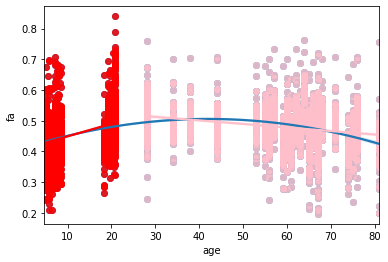

In [8]:
# test_data =  collectData('neuro/tractmeasures','macro_micro','','output_FiberStats.csv',subjects_data,colors,data_dir+'/tractmeasures-total_nodes.csv')
sns.regplot(x='age',y='fa',data=track_mean_data,order=2)
sns.regplot(x='age',y='fa',data=track_mean_data.loc[track_mean_data['classID'] == 'sandra'],color='pink')
sns.regplot(x='age',y='fa',data=track_mean_data.loc[track_mean_data['classID'] == 'LWX'],color='red')


In [8]:
import requests
import pandas as pd

# grab path and data objects
objects = requests.get('https://brainlife.io/api/warehouse/secondary/list/%s'%os.environ['PROJECT_ID']).json()

# subjects and paths
# subjects = []
# paths = []
# finish_dates = []

# # set up output
# data = pd.DataFrame()

# # loop through objects
# for obj in objects:
#     if obj['datatype']['name'] == datatype:
#         if datatype_tags in obj['output']['datatype_tags']:
#             if tags in obj['output']['tags']:
#                 finish_dates = np.append(finish_dates,obj["finish_date"])
#                 if obj['output']['meta']['subject'] in subjects:
#                     index = np.where(subjects == obj['output']['meta']['subject'])
#                     if finish_dates[index] < obj["finish_date"]:
#                         subjects = np.delete(subjects,index)
#                         paths = np.delete(paths,index)
#                         subjects = np.append(subjects,obj['output']['meta']['subject'])
#                         paths = np.append(paths,"input/"+obj["path"]+"/"+filename)
#                 else:
#                     subjects = np.append(subjects,obj['output']['meta']['subject'])
#                     paths = np.append(paths,"input/"+obj["path"]+"/"+filename)

# # sort paths by subject order
# paths = [x for _,x in sorted(zip(subjects,paths))]

for obj in objects:
    print(obj)

{'path': '602c2adc8b39741fee2750ef/602c2adc8b39742a572750f0/60117844c0810330b8b9efef', 'task_id': '602c2adc8b39742a572750f0', 'datatype': {'_id': '599f305ad1f46fec1759f363', 'name': 'neuro/tractmeasures'}, 'app': {'service': 'brainlife/app-stage', 'commit_id': '28e41d31f5b5bddba478ceb9c266bfd7f23b2864', 'name': 'Stage from archive'}, 'output': {'id': '60117844c0810330b8b9efef', 'datatype': '599f305ad1f46fec1759f363', 'meta': {'subject': '103'}, 'tags': [], 'datatype_tags': ['macro_micro'], 'subdir': '60117844c0810330b8b9efef', 'dataset_id': '60117844c0810330b8b9efef', 'project': '5ff894db41130de74f187fdf'}, 'finish_date': '2021-02-16T20:28:24.597Z'}


70